<a href="https://colab.research.google.com/github/135gayathri/Malicious-Social-Bot-Detection/blob/code/Malicious_Social_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import requests
from urllib.parse import urlparse
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


# Ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
data =pd.read_csv('/content/Modified_Bot_dataset_with_adjusted_url_features (1).csv')
data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,...,Friends Count,url,url frequency,url redirection,url text,url length,special_char_count,contains_login,contains_free,url win
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,...,3093,https://example.com/user947,16,1,user-dashboard,40,5,0,0,1
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,...,8665,https://example.com/user931,13,0,user-dashboard,27,5,0,0,0
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,...,1073,https://example.com/user976,15,1,user-dashboard,27,5,0,0,0
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,...,714,https://example.com/user353,14,1,click-here,31,9,0,0,0
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,...,6524,https://example.com/user13,16,1,login-page,49,7,1,1,1


In [ ]:
# Load and display the dataset
try:
    data = pd.read_csv("/content/Modified_Bot_dataset_with_adjusted_url_features (1).csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found.")

# Strip whitespace from column names (if necessary)
data.columns = data.columns.str.strip()

# Define your features (X) and target (y) variables
# Replace 'target_column' with the actual column name representing the target variable in your dataset
X = data.drop(columns=['Bot Label'])  # Example: 'target_column' could be 'is_bot' or similar
y = data['Bot Label']  # Set y as the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Data loaded successfully.


In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, average='weighted') * 100
    rec = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    print(f'\n{model_name} Evaluation:')
    print(f'Accuracy: {acc:.2f}%')
    print(f'Precision: {prec:.2f}%')
    print(f'Recall: {rec:.2f}%')
    print(f'F1 Score: {f1:.2f}%\n')

In [ ]:
try:
    data = pd.read_csv("/content/Modified_Bot_dataset_with_adjusted_url_features (1).csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found.")


Data loaded successfully.


In [ ]:
print(data.columns)


Index(['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count',
       'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At',
       'Hashtags', 'Friends Count', 'url', 'url frequency', 'url redirection',
       'url text', 'url length', 'special_char_count', 'contains_login',
       'contains_free', 'url win'],
      dtype='object')


In [ ]:
data.columns = data.columns.str.strip()


In [ ]:

def extract_url_features(url):
    # Initialize feature dictionary
    url_features = {
        'url_frequency': 0,
        'url_redirection': 0,
        'url_text': 0,
        'url_length': 0,
        'special_char_count': 0,
        'contains_login': 0,
        'contains_free': 0,
        'url_win': 0
    }

    if not url or not isinstance(url, str):
        # If URL is empty or not a string, return the default features
        return url_features

    # Count URL length
    url_features['url_length'] = len(url)

    # Count special characters in URL
    url_features['special_char_count'] = len(re.findall(r'[^a-zA-Z0-9]', url))

    # Check for specific words in URL (such as 'login', 'free', 'win')
    url_features['contains_login'] = int('login' in url.lower())
    url_features['contains_free'] = int('free' in url.lower())
    url_features['url_win'] = int('win' in url.lower())

    # Detect redirections by following URL
    try:
        response = requests.get(url, timeout=5, allow_redirects=True)
        if len(response.history) > 1:  # If there were redirects
            url_features['url_redirection'] = 1
    except requests.exceptions.RequestException:
        # In case of a request failure, assume no redirection
        url_features['url_redirection'] = 0

    return url_features




In [ ]:
# Handle potential NaN values by ensuring feature extraction returns complete data
def enhanced_extract_url_features_safe(url):
    """Improved and safe feature extraction with default values for completeness."""
    return {
        'url_length': len(url),
        'special_char_count': sum(1 for char in url if not char.isalnum()),
        'contains_login': int('login' in url.lower()),
        'contains_free': int('free' in url.lower()),
        'contains_win': int('win' in url.lower()),
        'num_subdomains': url.count('.'),
        'path_depth': url.count('/'),
        'query_length': len(url.split('?')[-1]) if '?' in url else 0,
    }

# Extract and normalize features again
X_safe = data['url'].apply(enhanced_extract_url_features_safe).apply(pd.Series)
X_normalized_safe = (X_safe - X_safe.mean()) / X_safe.std()

# Confirm no NaN values now and display sample data
X_normalized_safe.head(), X_normalized_safe.isnull().sum()


(   url_length  special_char_count  contains_login  contains_free  \
 0    0.318595                 NaN             NaN            NaN   
 1    0.318595                 NaN             NaN            NaN   
 2    0.318595                 NaN             NaN            NaN   
 3    0.318595                 NaN             NaN            NaN   
 4   -2.592013                 NaN             NaN            NaN   
 
    contains_win  num_subdomains  path_depth  query_length  
 0           NaN             NaN         0.0           NaN  
 1           NaN             NaN         0.0           NaN  
 2           NaN             NaN         0.0           NaN  
 3           NaN             NaN         0.0           NaN  
 4           NaN             NaN         0.0           NaN  ,
 url_length                0
 special_char_count    50000
 contains_login        50000
 contains_free         50000
 contains_win          50000
 num_subdomains        50000
 path_depth                0
 query_length 

In [ ]:


def preprocess_data(df):
    # Select only required columns, excluding columns to drop
    columns_to_keep = [col for col in df.columns if col not in [
        'id_str', 'screen_name', 'location', 'description', 'created_at', 'lang', 'status',
        'has_extended_profile', 'name'
    ]]
    df = df[columns_to_keep].copy()

    # Extract URL features in one go and concatenate to the main DataFrame
    if 'url' in df.columns:
        url_features_df = pd.DataFrame(
            [extract_url_features(url) if isinstance(url, str) and url.strip() else {key: 0 for key in extract_url_features('')}
             for url in df['url']]
        )
        df = pd.concat([df.reset_index(drop=True), url_features_df], axis=1)
        df.drop(columns=['url'], inplace=True)  # Drop the original 'url' column after extraction

    # Encode categorical features efficiently
    categorical_cols = ['Verified', 'default_profile']
    for col in categorical_cols:
        if col in df.columns:
            # Use pd.factorize instead of LabelEncoder for faster operation
            df[col] = pd.factorize(df[col])[0]
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame.")

    return df


In [ ]:
X_train_sample = X_train[:5000].drop(columns=['User ID'], errors='ignore').copy()
y_train_sample = y_train[:5000].copy()
X_test_sample = X_test[:5000].drop(columns=['User ID'], errors='ignore').copy()

# Define numeric and categorical columns
numeric_features = X_train_sample.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train_sample.select_dtypes(include=['object']).columns

# Preprocessor for numeric and categorical features
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

In [ ]:
# Verify column names
print("Columns in data:", data.columns)

# Ensure no extra whitespace in column names
data.columns = data.columns.str.strip()

# Separate features and labels
X = data.drop('Bot Label', axis=1)
y = data['Bot Label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


Columns in data: Index(['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count',
       'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At',
       'Hashtags', 'Friends Count', 'url', 'url frequency', 'url redirection',
       'url text', 'url length', 'special_char_count', 'contains_login',
       'contains_free', 'url win'],
      dtype='object')


In [ ]:
X_train_sample = X_train[:5000]  # Use only the first 500 samples for testing
y_train_sample = y_train[:5000]


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (35000, 20)
Shape of X_test: (15000, 20)


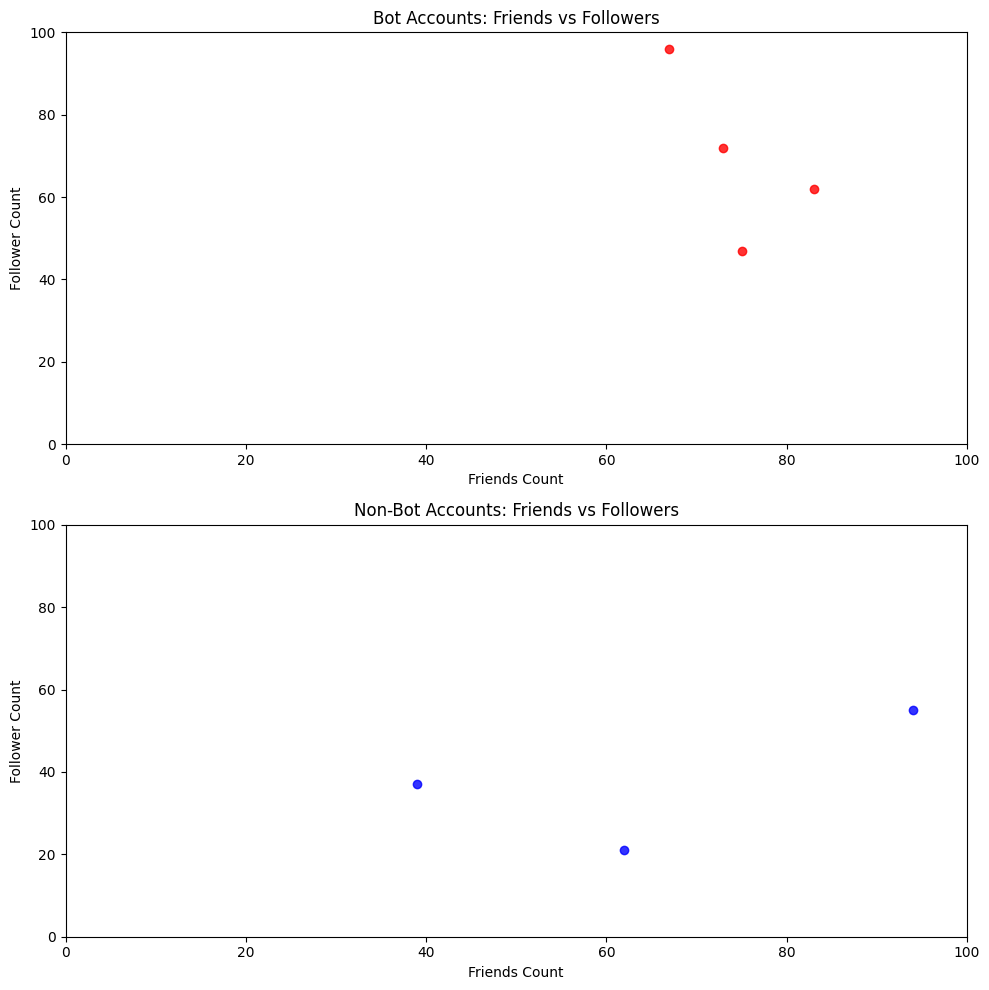

In [ ]:
# Visualization of Bot vs. Non-Bot Friends vs Followers
def plot_bot_vs_nonbot(data):
    bots = data[data['Bot Label'] == 1]
    non_bots = data[data['Bot Label'] == 0]

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.title('Bot Accounts: Friends vs Followers')
    sns.regplot(x=bots['Friends Count'], y=bots['Follower Count'], color='red')
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.subplot(2, 1, 2)
    plt.title('Non-Bot Accounts: Friends vs Followers')
    sns.regplot(x=non_bots['Friends Count'], y=non_bots['Follower Count'], color='blue')
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

plot_bot_vs_nonbot(data)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Define numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = numeric_features.drop(['User ID'])

# Preprocessor for SVM (with StandardScaler for numeric features)
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Preprocessor for MultinomialNB (with MinMaxScaler for numeric features)
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Pipeline for SVM model
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor_svm),
    ('classifier', SVC(kernel='linear', probability=True, C=0.5, random_state=1))
])

# Scale and fit the SVM model on the sample data
X_train_sample = X_train[:5000].copy()
y_train_sample = y_train[:5000].copy()
X_test_sample = X_test[:5000].copy()
y_test_sample = y_test[:5000].copy()

# Train and predict with SVM model
svm_pipeline.fit(X_train_sample, y_train_sample)
svm_preds = svm_pipeline.predict(X_test_sample)
evaluate_model(y_test_sample, svm_preds, "Support Vector Machine (SVM)")

# Pipeline for Multinomial Naive Bayes model
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor_nb),
    ('classifier', MultinomialNB())
])

# Train and predict with Multinomial Naive Bayes model
nb_pipeline.fit(X_train_sample, y_train_sample)
nb_preds = nb_pipeline.predict(X_test_sample)
evaluate_model(y_test_sample, nb_preds, "Multinomial Naive Bayes")


Support Vector Machine (SVM) Evaluation:
Accuracy: 99.88%
Precision: 99.88%
Recall: 99.88%
F1 Score: 99.88%


Multinomial Naive Bayes Evaluation:
Accuracy: 82.50%
Precision: 86.92%
Recall: 82.50%
F1 Score: 81.98%



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

# Drop 'User ID' column if it’s an identifier
X_train_sample = X_train[:5000].drop(columns=['User ID'], errors='ignore').copy()
y_train_sample = y_train[:5000].copy()
X_test_sample = X_test[:5000].drop(columns=['User ID'], errors='ignore').copy()

# Define numeric and categorical columns
numeric_features = X_train_sample.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train_sample.select_dtypes(include=['object']).columns

# Preprocessor for numeric and categorical features
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Create a pipeline for KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Fit the KNN model using the pipeline on the sample
knn_pipeline.fit(X_train_sample, y_train_sample)

# Make predictions on the test sample
knn_preds = knn_pipeline.predict(X_test_sample)
evaluate_model(y_test[:5000], knn_preds, "K-Nearest Neighbors")



K-Nearest Neighbors Evaluation:
Accuracy: 99.06%
Precision: 99.08%
Recall: 99.06%
F1 Score: 99.06%



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd

# Sample the dataset further to reduce memory usage
X_train_sample = X_train[:2000].copy()  # Adjust as needed for memory
y_train_sample = y_train[:2000].copy()
X_test_sample = X_test[:2000].copy()

# Define numeric and categorical columns
numeric_features = X_train_sample.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train_sample.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical features with safety checks for unseen categories
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    # Fit on training data and transform training data
    le.fit(X_train_sample[col].astype(str))
    X_train_sample[col] = le.transform(X_train_sample[col].astype(str))  # Transform training data

    # Handle unseen categories in test set: map to 'unknown' label (new category)
    unseen_categories = set(X_test_sample[col].astype(str)) - set(le.classes_)
    if unseen_categories:
        le.classes_ = np.append(le.classes_, list(unseen_categories))  # Add new classes for unseen categories
    X_test_sample[col] = le.transform(X_test_sample[col].astype(str))  # Transform test data

    label_encoders[col] = le  # Store the encoder for future use

# Preprocessor that scales numeric features only (categorical already encoded as numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Categorical features are already encoded as numeric
)

# Pipeline for RandomForest with very limited n_estimators
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=5, criterion='entropy', random_state=0))  # Reduce further if needed
])

# Fit the pipeline on the sample
pipeline.fit(X_train_sample, y_train_sample)

# Make predictions
rf_preds = pipeline.predict(X_test_sample)
evaluate_model(y_test[:2000], rf_preds, "Random Forest")



Random Forest Evaluation:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Sample the dataset further to reduce memory usage (Optional step to improve performance with larger datasets)
X_train_sample = X_train[:2000].copy()  # Adjust as needed for memory
y_train_sample = y_train[:2000].copy()
X_test_sample = X_test[:2000].copy()

# Define numeric and categorical columns
numeric_features = X_train_sample.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train_sample.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    # Fit the LabelEncoder on the training data and transform the training data
    le.fit(X_train_sample[col].astype(str))
    X_train_sample[col] = le.transform(X_train_sample[col].astype(str))  # Transform training data

    # Handle unseen categories in test data: map to 'unknown' label (new category)
    unseen_categories = set(X_test_sample[col].astype(str)) - set(le.classes_)
    if unseen_categories:
        le.classes_ = np.append(le.classes_, list(unseen_categories))  # Add new classes for unseen categories
    X_test_sample[col] = le.transform(X_test_sample[col].astype(str))  # Transform test data

    label_encoders[col] = le  # Store the encoder for future use

# Preprocessor that scales numeric features only (categorical already encoded as numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Categorical features are already encoded as numeric
)

# Decision Tree Classifier Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=0))  # Specify Decision Tree hyperparameters
])

# Fit the pipeline on the sampled dataset
dt_pipeline.fit(X_train_sample, y_train_sample)

# Make predictions
dt_preds = dt_pipeline.predict(X_test_sample)

# Evaluate the model
evaluate_model(y_test[:2000], dt_preds, "Decision Tree")



Decision Tree Evaluation:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%



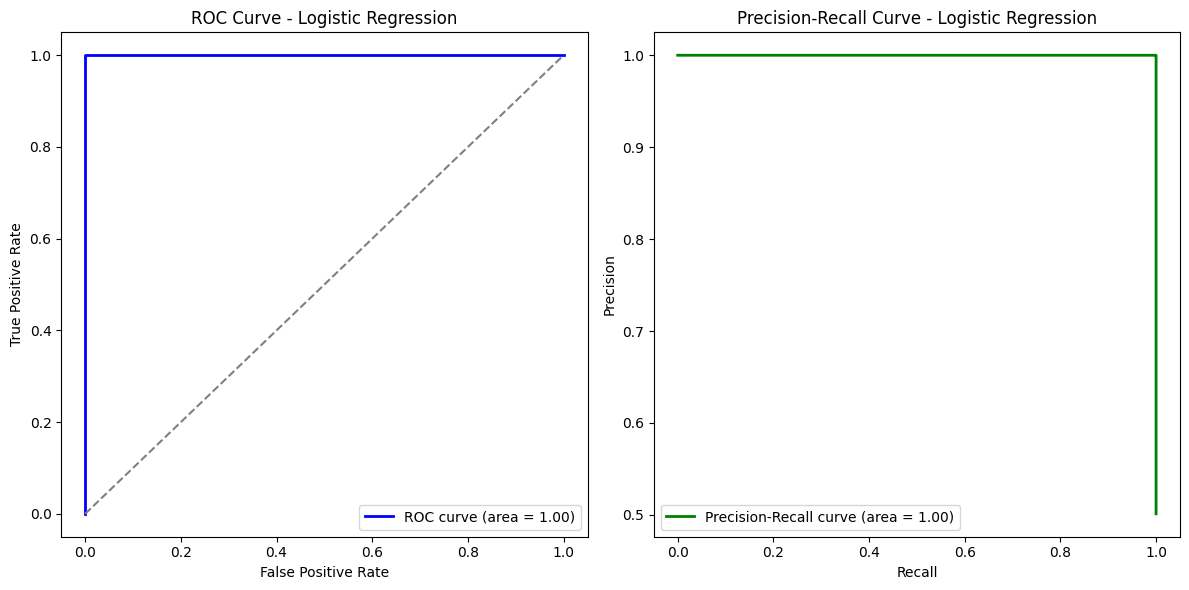

Logistic Regression Precision Score: 1.0
Logistic Regression Recall Score: 0.9978717744080873
Logistic Regression AUC (ROC): 1.0
Logistic Regression AUC (Precision-Recall): 1.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Handle NaN values in y_train and y_test
y_train.fillna('unknown', inplace=True)  # Replace NaNs with 'unknown'
y_test.fillna('unknown', inplace=True)   # Replace NaNs with 'unknown'

# Handle NaN values in X_train and X_test (for categorical and numeric features)
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('unknown')
X_test[categorical_columns] = X_test[categorical_columns].fillna('unknown')

# For numeric columns, fill NaNs with mean value
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].mean())
X_test[numeric_columns] = X_test[numeric_columns].fillna(X_train[numeric_columns].mean())

# Encode categorical columns using LabelEncoder (with handling for unseen labels)
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    le.fit(np.concatenate([X_train[col], X_test[col]]))  # Fit on both train and test combined
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Define numeric features and categorical features (after encoding)
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create a preprocessor for scaling numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Keep categorical features (already encoded as numeric)
)

# Logistic Regression with preprocessing
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))  # Increase max_iter if needed
])

# Fit the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Make predictions
lr_probs = lr_pipeline.predict_proba(X_test)[:, 1]
lr_preds = lr_pipeline.predict(X_test)

# Evaluate the model using ROC and Precision-Recall curves
def evaluate_model(y_true, y_preds, model_name):
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_true, lr_probs)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, lr_probs)
    pr_auc = auc(recall, precision)

    # Plot ROC curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    # Additional metrics
    print(f'{model_name} Precision Score: {precision_score(y_true, lr_preds)}')
    print(f'{model_name} Recall Score: {recall_score(y_true, lr_preds)}')
    print(f'{model_name} AUC (ROC): {roc_auc}')
    print(f'{model_name} AUC (Precision-Recall): {pr_auc}')

# Evaluate the Logistic Regression model
evaluate_model(y_test, lr_preds, "Logistic Regression")


In [ ]:
# Logistic Regression with ROC and Precision-Recall Curves
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_preds = lr.predict(X_test)

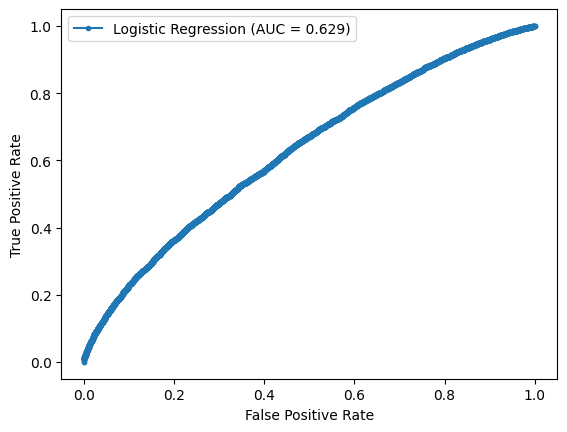

In [ ]:
# ROC Curve
lr_auc = roc_auc_score(y_test, lr_probs)
fpr, tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(fpr, tpr, marker='.', label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

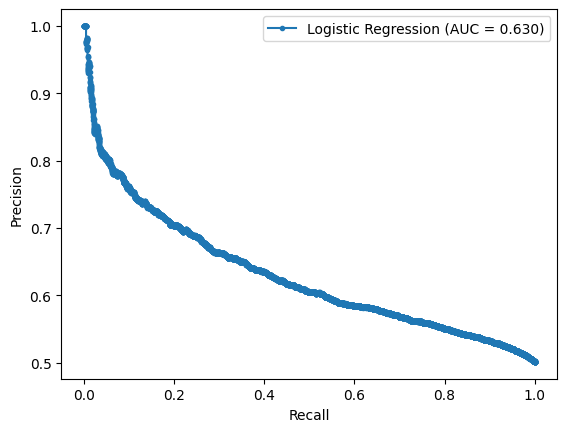

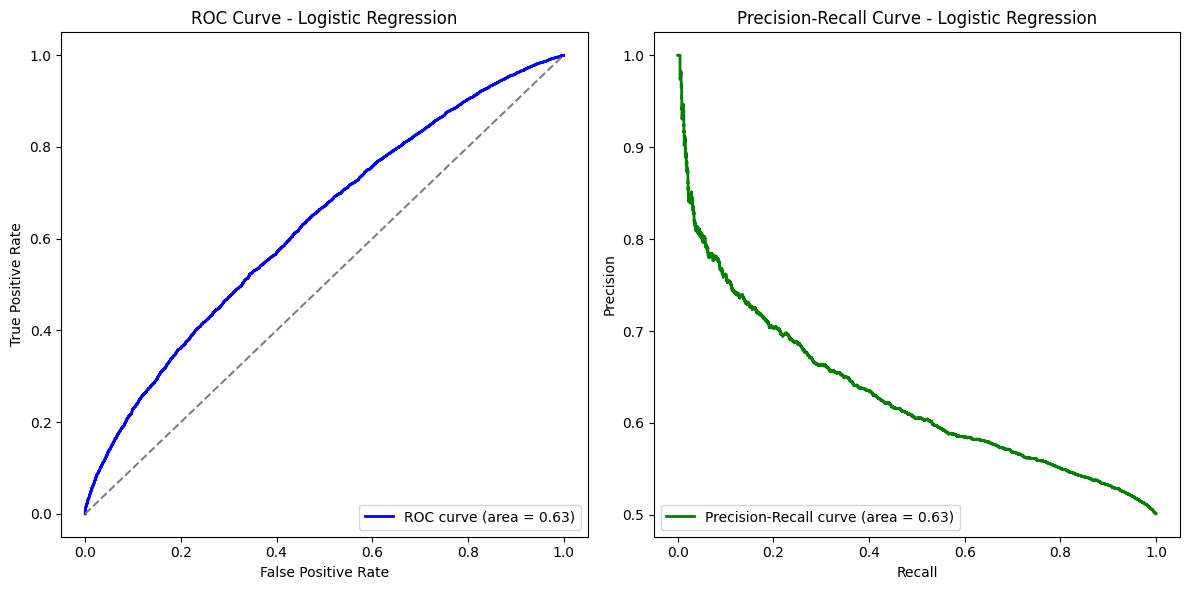

Logistic Regression Precision Score: 0.5879300928454396
Logistic Regression Recall Score: 0.572758712423517
Logistic Regression AUC (ROC): 0.6285997451789767
Logistic Regression AUC (Precision-Recall): 0.6301681864822344


In [ ]:
# Precision-Recall Curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_auc_pr = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression (AUC = {:.3f})'.format(lr_auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

evaluate_model(y_test, lr_preds, "Logistic Regression")

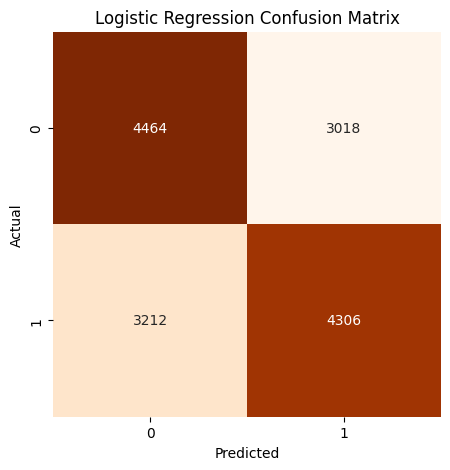

In [ ]:
# Confusion Matrix Visualization for Logistic Regression
conf_matrix = confusion_matrix(y_test, lr_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the BotDetectionEnvironment class
class BotDetectionEnvironment:
    def __init__(self, data):
        self.data = data
        self.action_space = [0, 1]  # 0: Non-Bot, 1: Bot
        self.state_space = range(len(data))  # Use index as state space (simple version)

    def reset(self):
        # Reset the environment and return initial state
        return random.choice(self.state_space)

    def step(self, action):
        state = random.choice(self.state_space)
        true_label = self.data.iloc[state]['Bot Label']

        # Define reward based on action and true label
        if action == true_label:
            reward = 1  # Correct classification
        else:
            reward = -1  # Incorrect classification

        done = True  # Since it's a simple classification task, the episode ends after one step
        return state, reward, done

# Define the QLearningAgent class
class QLearningAgent:
    def __init__(self, environment, learning_rate=0.05, discount_factor=0.9, exploration_prob=1.0, exploration_decay=0.995):
        self.env = environment
        self.q_table = np.zeros((len(environment.state_space), len(environment.action_space)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.exploration_decay = exploration_decay
        self.exploration_min = 0.01  # Prevent exploration from becoming too low

    def choose_action(self, state):
        # Exploration vs Exploitation strategy
        if random.uniform(0, 1) < self.exploration_prob:
            return random.choice(self.env.action_space)  # Explore
        return np.argmax(self.q_table[state])  # Exploit (choose action with highest Q-value)

    def update_q_table(self, state, action, reward, next_state):
        # Update Q-table using Q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state])  # Max Q value for next state
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_delta

    def decay_exploration(self):
        # Gradually decay exploration rate
        self.exploration_prob = max(self.exploration_min, self.exploration_prob * self.exploration_decay)

# Train the Q-learning agent
def train_agent(data, episodes=100, max_steps=50):
    env = BotDetectionEnvironment(data)  # Pass the data here
    agent = QLearningAgent(env)

    for episode in range(episodes):
        state = env.reset()
        for step in range(max_steps):  # Limit steps per episode
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            if done:
                break
        agent.decay_exploration()

    return agent

# Function to evaluate model performance using standard metrics
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance by calculating various metrics.

    :param y_true: True labels
    :param y_pred: Predicted labels
    :param model_name: Name of the model being evaluated
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Classify using the trained RL agent
def classify_with_rl_model(data, agent):
    classifications = []
    for _, row in data.iterrows():
        state = int(row['Bot Label'])  # Use Bot Label as state (actual label for simulation)
        action = agent.choose_action(state)  # Classify (action)
        classifications.append(action)
    return classifications

# Assuming 'data' contains the dataset and has a 'Bot Label' column for true labels
# Train the RL agent
trained_agent = train_agent(data, episodes=1000, max_steps=50)

# Classify the data using the trained RL agent
rl_classifications = classify_with_rl_model(data, trained_agent)

# True labels
y_true = data['Bot Label'].values

# Evaluate the RL agent's classifications
print("\nEvaluation of RL Classifier:")
evaluate_model(y_true, rl_classifications, model_name="Reinforcement Learning Classifier")



Evaluation of RL Classifier:
Evaluation for Reinforcement Learning Classifier:
Accuracy: 0.4999
Precision: 0.5263
Recall: 0.0052
F1 Score: 0.0103


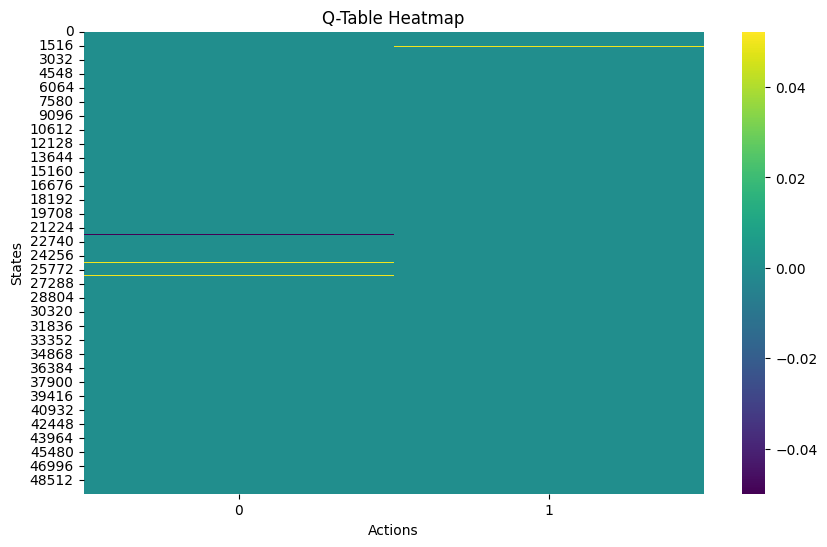

In [ ]:
#HeatMap
plt.figure(figsize=(10, 6))
sns.heatmap(trained_agent.q_table, annot=False, cmap='viridis', cbar=True, fmt='.1f')
plt.title("Q-Table Heatmap")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()


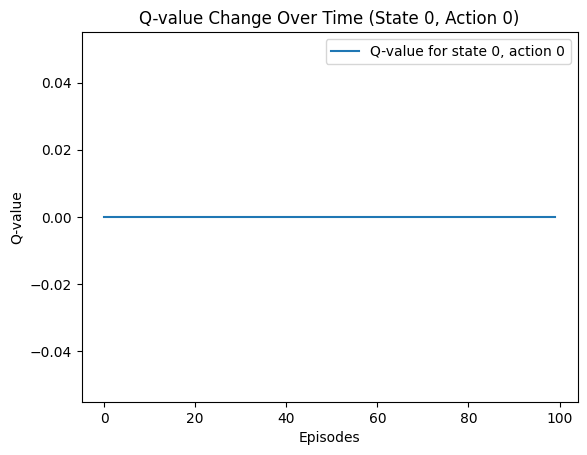

In [ ]:
# Store Q-tables after each episode for visualization
q_tables_over_time = []

def train_agent_with_q_plot(data, episodes=100, max_steps=50):
    env = BotDetectionEnvironment(data)
    agent = QLearningAgent(env)
    for episode in range(episodes):
        state = env.reset()
        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            if done:
                break
        agent.decay_exploration()
        q_tables_over_time.append(np.copy(agent.q_table))  # Store Q-table at each step

    return agent, q_tables_over_time

# Train and collect Q-tables over time
trained_agent, q_tables_over_time = train_agent_with_q_plot(data)

# Plot Q-values over episodes for a specific state-action pair (example: state 0, action 0)
episode_numbers = list(range(len(q_tables_over_time)))
q_values = [q_tables_over_time[i][0, 0] for i in episode_numbers]

plt.plot(episode_numbers, q_values, label="Q-value for state 0, action 0")
plt.xlabel("Episodes")
plt.ylabel("Q-value")
plt.title("Q-value Change Over Time (State 0, Action 0)")
plt.legend()
plt.show()


In [ ]:
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Bot Detection Environment
class BotDetectionEnvironment:
    def __init__(self):
        self.state_space = [0, 1]  # States: Non-Bot (0), Bot (1)
        self.action_space = [0, 1]  # Actions: Classify as Non-Bot (0) or Bot (1)
        self.state = random.choice(self.state_space)  # Initial state

    def step(self, action):
        reward = 1 if action == self.state else -1  # Reward: +1 for correct, -1 for incorrect
        self.state = random.choice(self.state_space)  # Randomly change state
        return self.state, reward

    def reset(self):
        self.state = random.choice(self.state_space)  # Random reset to a state
        return self.state


# Learning Automata Agent
class LearningAutomataAgent:
    def __init__(self, environment, learning_rate=0.1):
        self.env = environment
        self.action_probabilities = np.ones(len(environment.action_space)) / len(environment.action_space)  # Equal initial probabilities
        self.learning_rate = learning_rate

    def choose_action(self):
        return np.random.choice(self.env.action_space, p=self.action_probabilities)  # Select action based on probability

    def update_probabilities(self, action, reward):
        if reward > 0:  # Correct classification
            self.action_probabilities[action] += self.learning_rate * (1 - self.action_probabilities[action])
        else:  # Incorrect classification
            self.action_probabilities[action] -= self.learning_rate * self.action_probabilities[action]

        # Normalize probabilities to keep them in range [0, 1]
        self.action_probabilities = np.clip(self.action_probabilities, 0, 1)
        self.action_probabilities /= np.sum(self.action_probabilities)


# Train the Learning Automata Agent
def train_agent(episodes=100, max_steps=50):
    env = BotDetectionEnvironment()
    agent = LearningAutomataAgent(env)

    for episode in range(episodes):
        state = env.reset()
        for step in range(max_steps):
            action = agent.choose_action()
            next_state, reward = env.step(action)
            agent.update_probabilities(action, reward)
            state = next_state

    return agent

# Evaluate model performance by calculating various metrics
def evaluate_model(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Function to classify using the trained Learning Automata agent
def classify_with_la_model(data, agent):
    classifications = []
    for _, row in data.iterrows():
        state = int(row['Bot Label'])  # Actual label to simulate state
        action = agent.choose_action()  # Classification action based on probabilities
        classifications.append(action)
    return classifications

# Example: Assuming 'data' is your dataset and it has a 'Bot Label' column
# Load your dataset here
# data = pd.read_csv('your_data.csv')

# Train the learning automata agent
trained_agent = train_agent(episodes=100, max_steps=50)

# Classify using the learning automata agent
la_classifications = classify_with_la_model(data, trained_agent)

# Display results
print("Learning Automata-based Classifications (first 20000 samples):")
print(la_classifications[:20000])

# Evaluate the learning automata agent's classifications
y_true = data['Bot Label'].values  # True labels
print("\nEvaluation of Learning Automata Classifier:")
evaluate_model(y_true[:len(la_classifications)], la_classifications, "Learning Automata Classifier")


Learning Automata-based Classifications (first 20000 samples):
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 

Episode 1, Total Reward: -10
Episode 2, Total Reward: 0
Episode 3, Total Reward: -4
Episode 4, Total Reward: 12
Episode 5, Total Reward: 2
Episode 6, Total Reward: 6
Episode 7, Total Reward: 6
Episode 8, Total Reward: 0
Episode 9, Total Reward: 12
Episode 10, Total Reward: 4
Episode 11, Total Reward: 2
Episode 12, Total Reward: -6
Episode 13, Total Reward: -4
Episode 14, Total Reward: 0
Episode 15, Total Reward: 6
Episode 16, Total Reward: 8
Episode 17, Total Reward: 10
Episode 18, Total Reward: 4
Episode 19, Total Reward: 8
Episode 20, Total Reward: -2
Episode 21, Total Reward: -4
Episode 22, Total Reward: 8
Episode 23, Total Reward: 4
Episode 24, Total Reward: -4
Episode 25, Total Reward: -4
Episode 26, Total Reward: -6
Episode 27, Total Reward: 0
Episode 28, Total Reward: -12
Episode 29, Total Reward: -2
Episode 30, Total Reward: -4
Episode 31, Total Reward: 4
Episode 32, Total Reward: 0
Episode 33, Total Reward: 8
Episode 34, Total Reward: 8
Episode 35, Total Reward: -4
Episode 36,

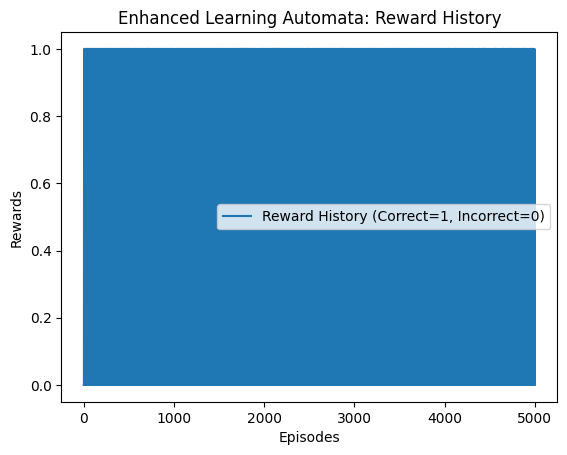

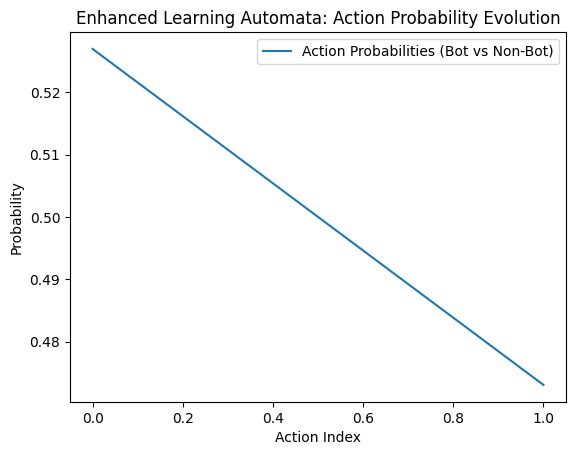

In [ ]:
#EnhancedLearningAutomataAgent
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the Bot Detection Environment
class BotDetectionEnvironment:
    def __init__(self):
        self.state_space = [0, 1]  # States: Non-Bot (0), Bot (1)
        self.action_space = [0, 1]  # Actions: Classify as Non-Bot (0) or Bot (1)
        self.state = random.choice(self.state_space)  # Initial state

    def step(self, action):
        # Reward: +1 for correct classification, -1 for incorrect
        reward = 1 if action == self.state else -1
        # Transition to the next random state
        self.state = random.choice(self.state_space)
        return self.state, reward

    def reset(self):
        # Reset to a random initial state
        self.state = random.choice(self.state_space)
        return self.state


# Enhanced Learning Automata Agent
class EnhancedLearningAutomataAgent:
    def __init__(self, environment, learning_rate=0.1, exploration_rate=1.0, decay_rate=0.995):
        self.env = environment
        self.action_probabilities = np.ones(len(environment.action_space)) / len(environment.action_space)  # Uniform distribution
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.decay_rate = decay_rate
        self.min_exploration_rate = 0.01
        self.reward_history = []

    def choose_action(self):
        # Exploration vs Exploitation
        if random.uniform(0, 1) < self.exploration_rate:
            action = np.random.choice(self.env.action_space)  # Exploration
        else:
            action = np.argmax(self.action_probabilities)  # Exploitation (Best action based on probability)
        return action

    def update_probabilities(self, action, reward):
        # Adaptive learning: increase or decrease probabilities based on reward
        if reward > 0:  # Correct classification
            self.action_probabilities[action] += self.learning_rate * (1 - self.action_probabilities[action])
        else:  # Incorrect classification
            self.action_probabilities[action] -= self.learning_rate * self.action_probabilities[action]

        # Normalize probabilities to keep them in range [0, 1]
        self.action_probabilities = np.clip(self.action_probabilities, 0, 1)
        self.action_probabilities /= np.sum(self.action_probabilities)

    def decay_exploration(self):
        # Decay the exploration rate over time (decaying epsilon-greedy)
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.decay_rate)

    def train(self, episodes=100, max_steps=50):
        for episode in range(episodes):
            state = self.env.reset()  # Reset environment for each episode
            total_reward = 0

            for step in range(max_steps):  # Limit steps per episode
                action = self.choose_action()
                next_state, reward = self.env.step(action)
                self.update_probabilities(action, reward)
                self.decay_exploration()
                total_reward += reward
                if reward > 0:
                    self.reward_history.append(1)  # Correct classification
                else:
                    self.reward_history.append(0)  # Incorrect classification
                if step == max_steps - 1:
                    break

            print(f"Episode {episode + 1}, Total Reward: {total_reward}")
        print("Training complete!")

# Train the Enhanced Learning Automata Agent
env = BotDetectionEnvironment()
agent = EnhancedLearningAutomataAgent(env)

agent.train(episodes=100, max_steps=50)

# Evaluate and visualize the action probabilities evolution
plt.plot(agent.reward_history, label="Reward History (Correct=1, Incorrect=0)")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Enhanced Learning Automata: Reward History')
plt.legend()
plt.show()

# Plot the action probabilities
plt.plot(agent.action_probabilities, label="Action Probabilities (Bot vs Non-Bot)")
plt.xlabel('Action Index')
plt.ylabel('Probability')
plt.title('Enhanced Learning Automata: Action Probability Evolution')
plt.legend()
plt.show()



In [ ]:
# Redefine and re-train EnhancedLearningAutomataAgent as before
class EnhancedLearningAutomataAgent:
    def __init__(self, environment, learning_rate=0.05, decay_rate=0.99):
        self.env = environment
        self.action_probabilities = {state: np.ones(len(environment.action_space)) / len(environment.action_space)
                                     for state in environment.state_space}  # Initialize uniform probabilities per state
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate  # Learning rate decay for stability in learning over time
        self.history = []  # Keep history of recent rewards to learn from patterns

    def choose_action(self, state):
        return np.random.choice(self.env.action_space, p=self.action_probabilities[state])  # Select action based on probabilities

    def update_probabilities(self, state, action, reward):
        # Adjust learning rate gradually over time for more stable convergence
        lr = self.learning_rate * self.decay_rate

        # Update based on reward, more aggressively for incorrect actions
        if reward > 0:  # Correct classification
            self.action_probabilities[state][action] += lr * (1 - self.action_probabilities[state][action])
        else:  # Incorrect classification
            self.action_probabilities[state][action] -= lr * self.action_probabilities[state][action]

        # Normalize probabilities to keep them in range [0, 1]
        self.action_probabilities[state] = np.clip(self.action_probabilities[state], 0, 1)
        self.action_probabilities[state] /= np.sum(self.action_probabilities[state])

    def decay_learning_rate(self):
        # Decay the learning rate over time
        self.learning_rate *= self.decay_rate

def train_agent(episodes=200, max_steps=100):
    env = BotDetectionEnvironment()
    agent = EnhancedLearningAutomataAgent(env)

    for episode in range(episodes):
        state = env.reset()
        for step in range(max_steps):  # Limit steps per episode
            action = agent.choose_action(state)
            next_state, reward = env.step(action)
            agent.update_probabilities(state, action, reward)
            state = next_state
        agent.decay_learning_rate()  # Decay learning rate gradually

    return agent

# Train enhanced learning automata with the new data structure
trained_agent = train_agent(episodes=200, max_steps=100)

# Classification function with enhanced learning automata and URL features
def classify_with_enhanced_la_model(data, agent):
    classifications = []
    for _, row in data.iterrows():
        state = int(row['Bot Label'])  # Actual label to simulate state
        action = agent.choose_action(state)  # Classification
        classifications.append(action)
    return classifications

# Perform classification and evaluation
la_classifications = classify_with_enhanced_la_model(data, trained_agent)
evaluate_model(y[:len(la_classifications)], la_classifications, "Enhanced Learning Automata Classifier with URL Features")

Evaluation for Enhanced Learning Automata Classifier with URL Features:
Accuracy: 0.9978
Precision: 0.9979
Recall: 0.9978
F1 Score: 0.9978


In [ ]:
import re
import requests

# Enhanced URL feature extraction based on patterns
def extract_url_features(url):
    url_features = {
        'url_length': len(url),
        'special_char_count': len(re.findall(r'[^a-zA-Z0-9]', url)),
        'contains_login': int('login' in url.lower()),
        'contains_free': int('free' in url.lower()),
        'url_win': int('win' in url.lower()),
        'url_redirection': 0,  # Will be checked via requests
        'has_https': int(url.lower().startswith('https://')),
        'contains_number': int(any(char.isdigit() for char in url)),
    }

    # Detect redirections by following URL
    try:
        response = requests.get(url, timeout=5, allow_redirects=True)
        if len(response.history) > 1:  # If there were redirects
            url_features['url_redirection'] = 1
    except requests.exceptions.RequestException:
        url_features['url_redirection'] = 0

    return url_features

# Rule-based URL classification
def classify_url(url):
    features = extract_url_features(url)

    # Heuristic for malicious URL based on feature patterns
    malicious_keywords = ['login', 'free', 'win', 'giveaway']
    legitimate_keywords = ['secure', 'trusted', 'bank', 'login', 'https']

    # Check for malicious patterns
    if any(keyword in url.lower() for keyword in malicious_keywords):
        return "MALICIOUS"

    # Check for legitimate patterns
    if features['has_https'] and not features['contains_login'] and not features['contains_free']:
        return "LEGITIMATE"

    # Further checks: if URL redirects frequently or contains suspicious elements
    if features['url_redirection'] or features['contains_number']:
        return "MALICIOUS"

    return "LEGITIMATE"  # Default classification



In [ ]:
# Example usage with user input
url = input("Enter a URL to classify (Malicious or Legitimate): ")
prediction = classify_url(url)
print(f"The URL is classified as: {prediction}")

Enter a URL to classify (Malicious or Legitimate): https://x.com/SunRisers/status/1851958588388020544
The URL is classified as: LEGITIMATE
